In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, RationalQuadratic
from sklearn.preprocessing import StandardScaler, PowerTransformer, MinMaxScaler
from sklearn.model_selection import train_test_split
from skopt import BayesSearchCV
from skopt.space import Categorical


from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error

data_dir = 'data'

In [6]:
df = pd.read_csv(os.path.join(data_dir, 'final_data_log_targets.csv'))

df.head()

,TAU_bl,PTAU_bl,ABETA_bl,PTEDUCAT,MMSE_bl,EcogPtTotal_bl,LDELTOTAL_BL,mPACCdigit_bl,mPACCtrailsB_bl,RAVLT_immediate_bl,...,SUVr_Vermis_1_2.nii,SUVr_Vermis_3.nii,SUVr_Vermis_4_5.nii,SUVr_Vermis_6.nii,SUVr_Vermis_7.nii,SUVr_Vermis_8.nii,SUVr_Vermis_9.nii,SUVr_Vermis_10.nii,SUVr_VTA_L.nii,SUVr_VTA_R.nii
0,4.617099,2.310553,731.8,-1.0,-2.0,-0.179246,15.0,1.722587,1.525525,0.440843,...,0.003369,0.011351,0.030880,0.018253,0.009289,0.011917,0.008881,0.006231,0.000712,0.000659
1,5.783210,3.537766,780.3,-2.0,-3.0,0.216812,7.0,0.221907,0.032151,0.582690,...,0.003325,0.011246,0.029007,0.016903,0.009108,0.012666,0.008033,0.006029,0.000770,0.000699
2,6.195221,3.973682,832.7,0.5,0.5,-0.275793,3.0,-1.111149,-1.035326,-0.784427,...,0.003402,0.011694,0.033622,0.019224,0.010413,0.012902,0.007799,0.005730,0.000804,0.000760
3,4.683981,2.356126,590.4,3.0,3.0,-0.545607,11.0,0.306061,0.339234,0.002003,...,0.003367,0.011986,0.034076,0.019834,0.010011,0.012782,0.009789,0.006613,0.000748,0.000675
4,5.509793,3.210037,466.1,1.0,0.5,0.040211,18.0,1.883734,1.336483,0.512023,...,0.002935,0.009448,0.028740,0.017897,0.009361,0.012595,0.008533,0.005170,0.000675,0.000675


# Predict ABETA baseline 

Features are cog scores and pet suvr's
Drop the other CSF from the features
Target is ABETA_bl


### Data set-up


In [5]:
X = df.drop(columns = ['ABETA_bl', 'TAU_bl', 'PTAU_bl'], axis = 1)
y = df['ABETA_bl']

scaler = StandardScaler()


X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(434, 175) (109, 175) (434,) (109,)


In [6]:
def make_kernel(name):
    if name == "RQ_1e-5":
        return RationalQuadratic(length_scale=1e-5)
    elif name == "RQ_1e-4":
        return RationalQuadratic(length_scale=1e-4)
    elif name == "RQ_1e-3":
        return RationalQuadratic(length_scale=1e-3)
    elif name == "RQ_1e-2":
        return RationalQuadratic(length_scale=1e-2)
    elif name == "RQ_1e-1":
        return RationalQuadratic(length_scale=1e-1)
    elif name == "RQ_1e0":
        return RationalQuadratic(length_scale=1e0)
    elif name == "RQ_1e1":
        return RationalQuadratic(length_scale=1e1)
    elif name == "RQ_1e2":
        return RationalQuadratic(length_scale=1e2)
    else:
        raise ValueError(f"Unknown kernel: {name}")


search_params = {
    'kernel': Categorical(["RQ_1e-5", "RQ_1e-4", "RQ_1e-3", "RQ_1e-2", "RQ_1e-1", "RQ_1e0", "RQ_1e1", "RQ_1e2"]),
    'alpha': (1e-5, 1e2, 'log-uniform'),
}

class GPRWrapper(GaussianProcessRegressor):
    def set_params(self, **params):
        if "kernel" in params and isinstance(params["kernel"], str):
            params["kernel"] = make_kernel(params["kernel"])
        
        return super().set_params(**params)

gpr = GPRWrapper(
    kernel=RationalQuadratic(length_scale=1.0), alpha=25e-2, n_restarts_optimizer=30, random_state=42, normalize_y=True
)

search = BayesSearchCV(
    gpr,
    search_params,
    n_iter=50,
    cv=5,
    n_jobs=-1,
    verbose=1,
    random_state=42,
)

search.fit(X_train, y_train)

print(f'Best parameters: {search.best_params_}, Best score: {search.best_score_:.2f}')


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

c:\Users\huw\OneDrive\Documents\Research_Internship\MPhys_scripts\.conda\Lib\site-packages\sklearn\gaussian_process\kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


### Model set up

length scale places importance on different features

In [7]:

kernel = RationalQuadratic(length_scale= 1e1,
                           alpha = 0.01)

gpr = GaussianProcessRegressor(kernel=kernel,
                               alpha = 0.209,
                               n_restarts_optimizer= 30,
                               random_state=42,
                               normalize_y= True)

gpr.fit(X_train, y_train)

c:\Users\huw\OneDrive\Documents\Research_Internship\MPhys_scripts\.conda\Lib\site-packages\sklearn\gaussian_process\kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


,kernel,RationalQuadr...ngth_scale=10)
,alpha,0.209
,optimizer,'fmin_l_bfgs_b'
,n_restarts_optimizer,30
,normalize_y,True
,copy_X_train,True
,n_targets,None
,random_state,42
,kernel__length_scale,10.0
,kernel__alpha,0.01
,kernel__length_scale_bounds,"(1e-05, ...)"


<bound method BaseEstimator.get_params of GaussianProcessRegressor(alpha=0.209,
                         kernel=RationalQuadratic(alpha=0.01, length_scale=10),
                         n_restarts_optimizer=30, normalize_y=True,
                         random_state=42)>

In [20]:
rs = np.random.randint(1,75)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=rs)

rs

70

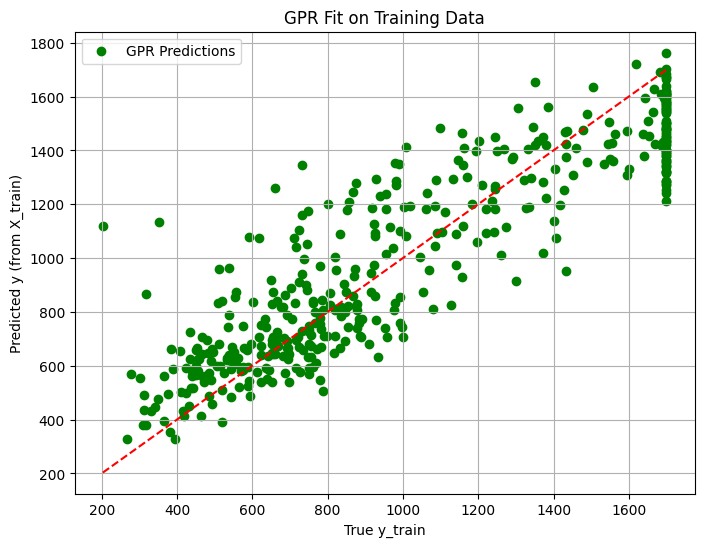

MSE: 42114.98274758731
Rsquared: 0.7974612435534985
RMSE: 205.21935276086248


In [21]:
y_mean_train, y_std_train = gpr.predict(X_train, return_std= True)

plt.figure(figsize=(8, 6))
plt.scatter(y_train, 
            y_mean_train, 
            color='green', 
            label='GPR Predictions')
plt.plot([y_train.min(), 
          y_train.max()],
         [y_train.min(),
          y_train.max()],
         'r--') 
plt.xlabel("True y_train")
plt.ylabel("Predicted y (from X_train)")
plt.title("GPR Fit on Training Data")
plt.legend()
plt.grid(True)
plt.show()

rmse = root_mean_squared_error(y_train, y_mean_train)
mse = mean_squared_error(y_train, y_mean_train)
r2 = r2_score(y_train, y_mean_train)

print(f"MSE: {mse}")
print(f"Rsquared: {r2}")
print(f"RMSE: {rmse}")

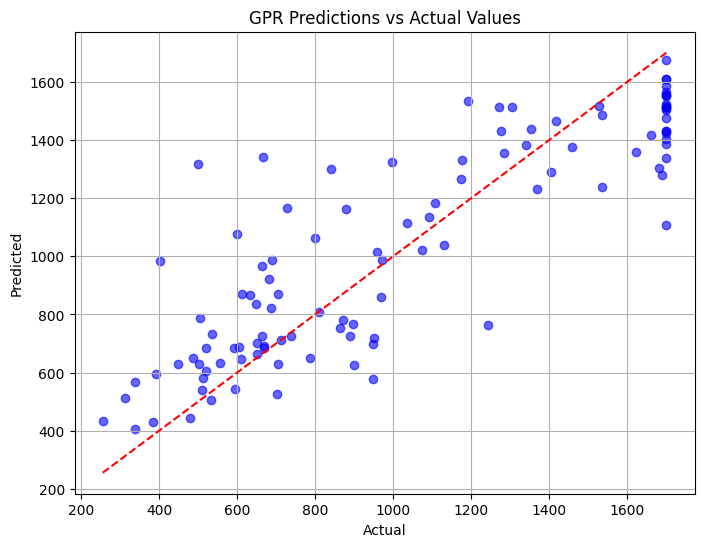

RMSE: 235.99220217452523
MSE: 55692.31948718199
Rsquared: 0.746307427998756


In [22]:
y_mean_test, y_std_train = gpr.predict(X_test, return_std= True)

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_mean_test, color='blue', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # reference line
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("GPR Predictions vs Actual Values")
plt.grid(True)
plt.show()

rmse = root_mean_squared_error(y_test, y_mean_test)
mse = mean_squared_error(y_test, y_mean_test)
r2 = r2_score(y_test, y_mean_test)

print(f"RMSE: {rmse}")
print(f"MSE: {mse}")
print(f"Rsquared: {r2}")

# Predict pTAU 

In [32]:
X = df.drop(columns = ['ABETA_bl', 'TAU_bl', 'PTAU_bl'], axis = 1)
y = df['PTAU_bl']


scaler = StandardScaler()

X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(434, 175) (109, 175) (434,) (109,)


In [34]:
kernel = RationalQuadratic(length_scale= 1e-3,
                                  alpha = 0.01)

gpr = GaussianProcessRegressor(kernel=kernel,
                               alpha = 0.485,
                               n_restarts_optimizer= 30,
                               random_state=42,
                               normalize_y= True)

gpr.fit(X_train, y_train)

c:\Users\huw\OneDrive\Documents\Research_Internship\MPhys_scripts\.conda\Lib\site-packages\sklearn\gaussian_process\kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


,kernel,RationalQuadr...h_scale=0.001)
,alpha,0.485
,optimizer,'fmin_l_bfgs_b'
,n_restarts_optimizer,30
,normalize_y,True
,copy_X_train,True
,n_targets,None
,random_state,42
,kernel__length_scale,0.001
,kernel__alpha,0.01
,kernel__length_scale_bounds,"(1e-05, ...)"


In [ ]:
rs = np.random.randint(1,75)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=rs)

rs

29

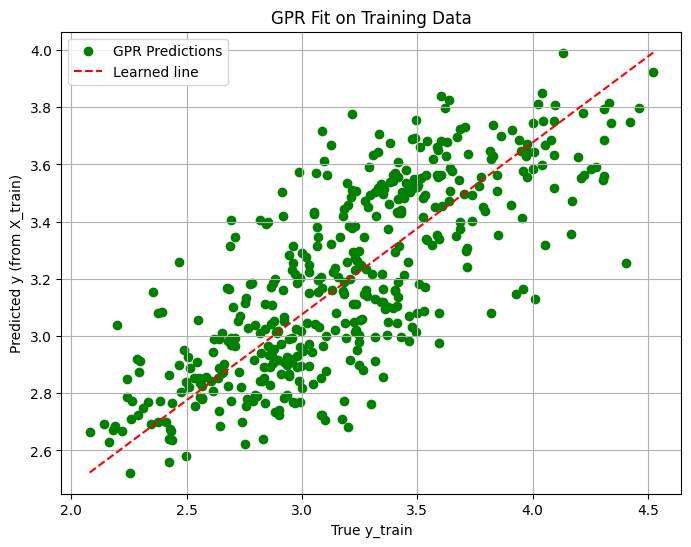

RMSE: 0.3270765321357334
MSE: 0.10697905787393744
Rsquared: 0.5768602472663564


In [47]:
y_mean_train, y_std_train = gpr.predict(X_train, return_std= True)

plt.figure(figsize=(8, 6))
plt.scatter(y_train, y_mean_train, color='green', label='GPR Predictions')
plt.plot([y_train.min(), y_train.max()],
         [y_mean_train.min(), y_mean_train.max()],
         'r--',
         label = 'Learned line') 
plt.xlabel("True y_train")
plt.ylabel("Predicted y (from X_train)")
plt.title("GPR Fit on Training Data")
plt.legend()
plt.grid(True)
plt.show()

rmse = root_mean_squared_error(y_train, y_mean_train)
mse = mean_squared_error(y_train, y_mean_train)
r2 = r2_score(y_train, y_mean_train)
print(f"RMSE: {rmse}")
print(f"MSE: {mse}")
print(f"Rsquared: {r2}")

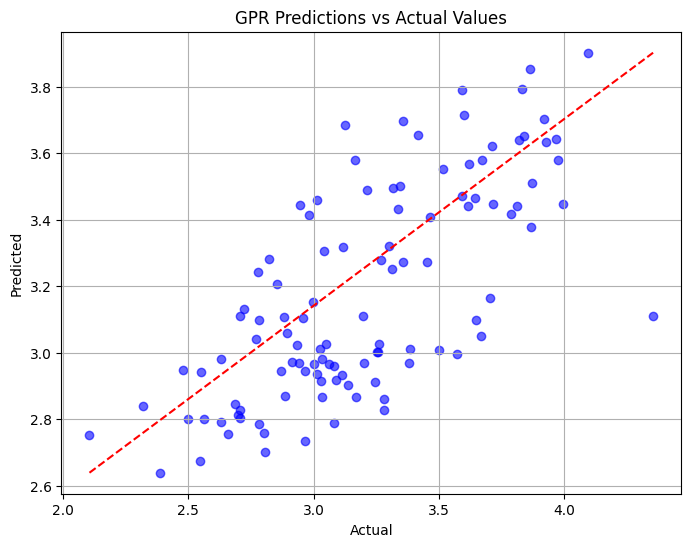

RMSE: 0.310875310731857
MSE: 0.09664345882262863
Rsquared: 0.5060132905634893


In [48]:
y_mean_test, y_std_train = gpr.predict(X_test, return_std= True)

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_mean_test, color='blue', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_mean_test.min(), y_mean_test.max()], 'r--')  # reference line
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("GPR Predictions vs Actual Values")
plt.grid(True)
plt.show()

rmse = root_mean_squared_error(y_test, y_mean_test)
mse = mean_squared_error(y_test, y_mean_test)
r2 = r2_score(y_test, y_mean_test)

print(f"RMSE: {rmse}")
print(f"MSE: {mse}")
print(f"Rsquared: {r2}")

## BayesSearchCV hyperparameter tuning


In [33]:
def make_kernel(name):
    if name == "RQ_1e-5":
        return RationalQuadratic(length_scale=1e-5)
    elif name == "RQ_1e-4":
        return RationalQuadratic(length_scale=1e-4)
    elif name == "RQ_1e-3":
        return RationalQuadratic(length_scale=1e-3)
    elif name == "RQ_1e-2":
        return RationalQuadratic(length_scale=1e-2)
    elif name == "RQ_1e-1":
        return RationalQuadratic(length_scale=1e-1)
    elif name == "RQ_1e0":
        return RationalQuadratic(length_scale=1e0)
    elif name == "RQ_1e1":
        return RationalQuadratic(length_scale=1e1)
    elif name == "RQ_1e2":
        return RationalQuadratic(length_scale=1e2)
    else:
        raise ValueError(f"Unknown kernel: {name}")


search_params = {
    'kernel': Categorical(["RQ_1e-5", "RQ_1e-4", "RQ_1e-3", "RQ_1e-2", "RQ_1e-1", "RQ_1e0", "RQ_1e1", "RQ_1e2"]),
    'alpha': (1e-5, 1e2, 'log-uniform'),
}

class GPRWrapper(GaussianProcessRegressor):
    def set_params(self, **params):
        if "kernel" in params and isinstance(params["kernel"], str):
            params["kernel"] = make_kernel(params["kernel"])
        
        return super().set_params(**params)

gpr = GPRWrapper(
    kernel=RationalQuadratic(length_scale=1.0), alpha=25e-2, n_restarts_optimizer=30, random_state=42, normalize_y=True
)

search = BayesSearchCV(
    gpr,
    search_params,
    n_iter=50,
    cv=5,
    n_jobs=-1,
    verbose=1,
    random_state=42,
)

search.fit(X_train, y_train)

print(f'Best parameters: {search.best_params_}, Best score: {search.best_score_:.2f}')

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

c:\Users\huw\OneDrive\Documents\Research_Internship\MPhys_scripts\.conda\Lib\site-packages\sklearn\gaussian_process\kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


# Predict TAU

In [51]:
X = df.drop(columns = ['ABETA_bl', 'TAU_bl', 'PTAU_bl'], axis = 1)
y = df['TAU_bl']

scaler = StandardScaler()

X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=rs)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(434, 175) (109, 175) (434,) (109,)


In [52]:
def make_kernel(name):
    if name == "RQ_1e-5":
        return RationalQuadratic(length_scale=1e-5)
    elif name == "RQ_1e-4":
        return RationalQuadratic(length_scale=1e-4)
    elif name == "RQ_1e-3":
        return RationalQuadratic(length_scale=1e-3)
    elif name == "RQ_1e-2":
        return RationalQuadratic(length_scale=1e-2)
    elif name == "RQ_1e-1":
        return RationalQuadratic(length_scale=1e-1)
    elif name == "RQ_1e0":
        return RationalQuadratic(length_scale=1e0)
    elif name == "RQ_1e1":
        return RationalQuadratic(length_scale=1e1)
    elif name == "RQ_1e2":
        return RationalQuadratic(length_scale=1e2)
    else:
        raise ValueError(f"Unknown kernel: {name}")
    


search_params = {
    'kernel': Categorical(["RQ_1e-5", "RQ_1e-4", "RQ_1e-3", "RQ_1e-2", "RQ_1e-1", "RQ_1e0", "RQ_1e1", "RQ_1e2"]),
    'alpha': (1e-5, 1e2, 'log-uniform'),
}

class GPRWrapper(GaussianProcessRegressor):
    def set_params(self, **params):
        if "kernel" in params and isinstance(params["kernel"], str):
            params["kernel"] = make_kernel(params["kernel"])
        
        return super().set_params(**params)

gpr = GPRWrapper(
    kernel=RationalQuadratic(length_scale=1.0), alpha=25e-2, n_restarts_optimizer=30, random_state=42, normalize_y=True
)

search = BayesSearchCV(
    gpr,
    search_params,
    n_iter=50,
    cv=5,
    n_jobs=-1,
    verbose=1,
    random_state=42,
)

search.fit(X_train, y_train)

print(f'Best parameters: {search.best_params_}, Best score: {search.best_score_:.2f}')

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

c:\Users\huw\OneDrive\Documents\Research_Internship\MPhys_scripts\.conda\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge after 23 iteration(s) (status=2):
ABNORMAL: 

You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Best parameters: OrderedDict([('alpha', 0.6673925884450314), ('kernel', 'RQ_1e0')]), Best score: 0.35


c:\Users\huw\OneDrive\Documents\Research_Internship\MPhys_scripts\.conda\Lib\site-packages\sklearn\gaussian_process\kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


In [53]:
kernel = RationalQuadratic(length_scale= 1e0,
                                  alpha = 0.01)

gpr = GaussianProcessRegressor(kernel=kernel,
                               alpha = 0.667,
                               n_restarts_optimizer= 30,
                               random_state=42,
                               normalize_y= True)

gpr.fit(X_train, y_train)

c:\Users\huw\OneDrive\Documents\Research_Internship\MPhys_scripts\.conda\Lib\site-packages\sklearn\gaussian_process\kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


,kernel,RationalQuadr...ength_scale=1)
,alpha,0.667
,optimizer,'fmin_l_bfgs_b'
,n_restarts_optimizer,30
,normalize_y,True
,copy_X_train,True
,n_targets,None
,random_state,42
,kernel__length_scale,1.0
,kernel__alpha,0.01
,kernel__length_scale_bounds,"(1e-05, ...)"


In [60]:
rs = np.random.randint(1,75)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=rs)

rs

64

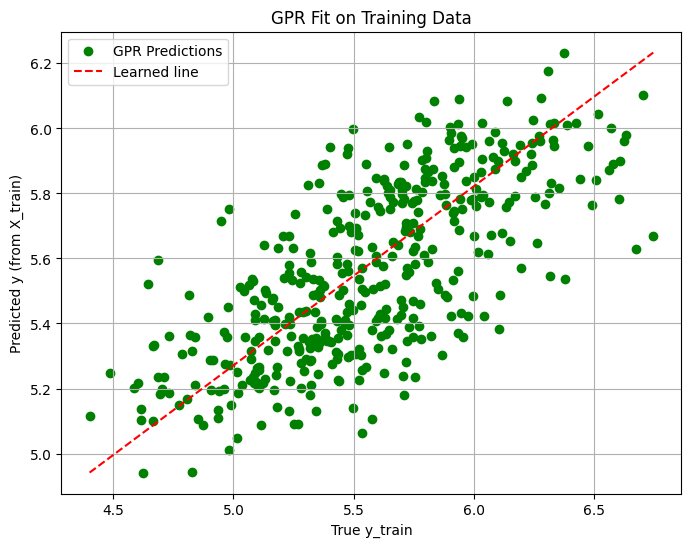

RMSE: 0.324985233446831
MSE: 0.10561540195849124
Rsquared: 0.48741898797018457


In [61]:
y_mean_train, y_std_train = gpr.predict(X_train, return_std= True)

plt.figure(figsize=(8, 6))
plt.scatter(y_train, y_mean_train, color='green', label='GPR Predictions')
plt.plot([y_train.min(), y_train.max()],
         [y_mean_train.min(), y_mean_train.max()],
         'r--',
         label = 'Learned line') 
plt.xlabel("True y_train")
plt.ylabel("Predicted y (from X_train)")
plt.title("GPR Fit on Training Data")
plt.legend()
plt.grid(True)
plt.show()

rmse = root_mean_squared_error(y_train, y_mean_train)
mse = mean_squared_error(y_train, y_mean_train)
r2 = r2_score(y_train, y_mean_train)

print(f"RMSE: {rmse}")
print(f"MSE: {mse}")
print(f"Rsquared: {r2}")

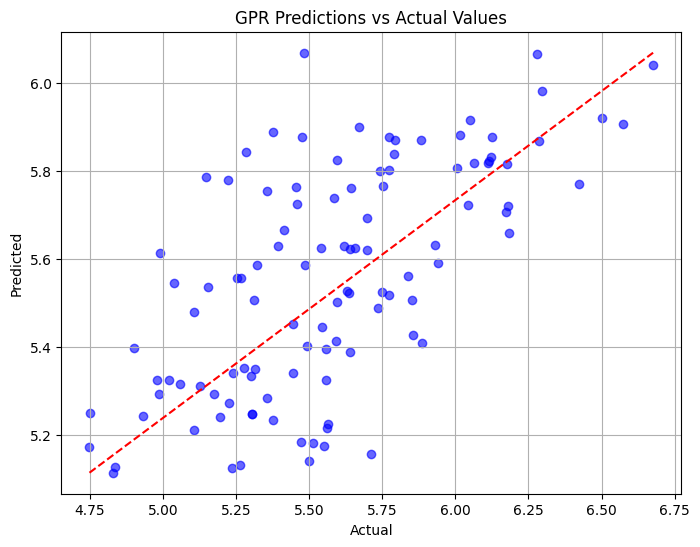

RMSE: 0.31269772879260715
MSE: 0.09777986959205491
Rsquared: 0.4194732696678185


In [62]:
y_mean_test, y_std_train = gpr.predict(X_test, return_std= True)

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_mean_test, color='blue', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_mean_test.min(), y_mean_test.max()], 'r--')  # reference line
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("GPR Predictions vs Actual Values")
plt.grid(True)
plt.show()

rmse = root_mean_squared_error(y_test, y_mean_test)
mse = mean_squared_error(y_test, y_mean_test)
r2 = r2_score(y_test, y_mean_test)

print(f"RMSE: {rmse}")
print(f"MSE: {mse}")
print(f"Rsquared: {r2}")

# MTL

In [63]:
X = df.drop(columns = ['ABETA_bl', 'TAU_bl', 'PTAU_bl'], axis = 1)
y = df.filter(['ABETA_bl','PTAU_bl', 'TAU_bl'])



X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(434, 175) (109, 175) (434, 3) (109, 3)


In [64]:
def make_kernel(name):
    if name == "RQ_1e-5":
        return RationalQuadratic(length_scale=1e-5)
    elif name == "RQ_1e-4":
        return RationalQuadratic(length_scale=1e-4)
    elif name == "RQ_1e-3":
        return RationalQuadratic(length_scale=1e-3)
    elif name == "RQ_1e-2":
        return RationalQuadratic(length_scale=1e-2)
    elif name == "RQ_1e-1":
        return RationalQuadratic(length_scale=1e-1)
    elif name == "RQ_1e0":
        return RationalQuadratic(length_scale=1e0)
    elif name == "RQ_1e1":
        return RationalQuadratic(length_scale=1e1)
    elif name == "RQ_1e2":
        return RationalQuadratic(length_scale=1e2)
    else:
        raise ValueError(f"Unknown kernel: {name}")
    


search_params = {
    'kernel': Categorical(["RQ_1e-5", "RQ_1e-4", "RQ_1e-3", "RQ_1e-2", "RQ_1e-1", "RQ_1e0", "RQ_1e1", "RQ_1e2"]),
    'alpha': (1e-5, 1e2, 'log-uniform'),
}

class GPRWrapper(GaussianProcessRegressor):
    def set_params(self, **params):
        if "kernel" in params and isinstance(params["kernel"], str):
            params["kernel"] = make_kernel(params["kernel"])
        
        return super().set_params(**params)

gpr = GPRWrapper(
    kernel=RationalQuadratic(length_scale=1.0), alpha=25e-2, n_restarts_optimizer=30, random_state=42, normalize_y=True
)

search = BayesSearchCV(
    gpr,
    search_params,
    n_iter=50,
    cv=5,
    n_jobs=-1,
    verbose=1,
    random_state=42,
)

search.fit(X_train, y_train)

print(f'Best parameters: {search.best_params_}, Best score: {search.best_score_:.2f}')

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

c:\Users\huw\OneDrive\Documents\Research_Internship\MPhys_scripts\.conda\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge after 19 iteration(s) (status=2):
ABNORMAL: 

You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
c:\Users\huw\OneDrive\Documents\Research_Internship\MPhys_scripts\.conda\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge after 26 iteration(s) (status=2):
ABNORMAL: 

You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Best parameters: OrderedDict([('alpha', 0.45650897672113366), ('kernel', 'RQ_1e1')]), Best score: 0.49


c:\Users\huw\OneDrive\Documents\Research_Internship\MPhys_scripts\.conda\Lib\site-packages\sklearn\gaussian_process\kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


In [69]:
kernel = RationalQuadratic(length_scale= 1e1, alpha = 0.01)

gpr = GaussianProcessRegressor(kernel=kernel,
                               alpha = 0.457,
                               n_restarts_optimizer= 30,
                               random_state=42,
                               normalize_y= True)

gpr.fit(X_train, y_train)

c:\Users\huw\OneDrive\Documents\Research_Internship\MPhys_scripts\.conda\Lib\site-packages\sklearn\gaussian_process\kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter alpha is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


,kernel,RationalQuadr...ngth_scale=10)
,alpha,0.457
,optimizer,'fmin_l_bfgs_b'
,n_restarts_optimizer,30
,normalize_y,True
,copy_X_train,True
,n_targets,None
,random_state,42
,kernel__length_scale,10.0
,kernel__alpha,0.01
,kernel__length_scale_bounds,"(1e-05, ...)"


In [95]:
rs = np.random.randint(1,75)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=rs)

rs

72

# ABETA

In [96]:
target = 'ABETA_bl'

In [97]:
target_y_train = y_train[target]
target_y_test  = y_test[target]

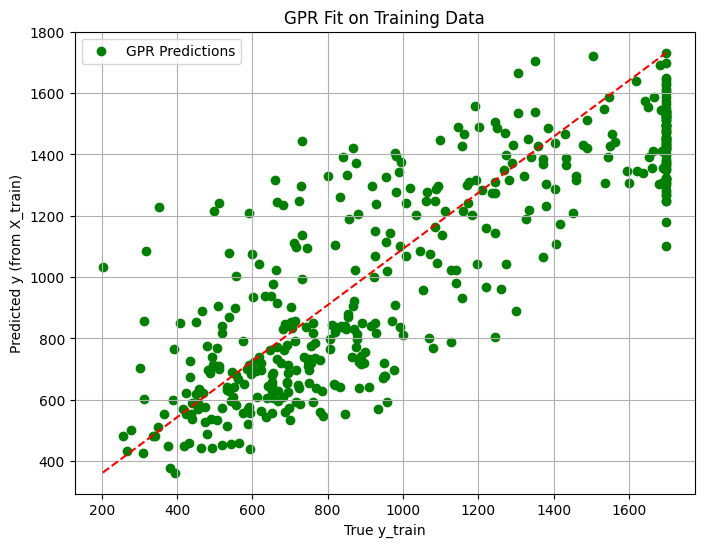

RMSE: 246.52476263174304
MSE: 60774.45859063725
Rsquared: 0.7071985128676987


In [98]:
y_mean_train, y_std_train = gpr.predict(X_train, return_std= True)


target_y_mean_train = y_mean_train[:,0]

plt.figure(figsize=(8, 6))
plt.scatter(target_y_train, target_y_mean_train, color='green', label='GPR Predictions')
plt.plot([target_y_train.min(), target_y_train.max()],
         [target_y_mean_train.min(), target_y_mean_train.max()],
         'r--') 
plt.xlabel("True y_train")
plt.ylabel("Predicted y (from X_train)")
plt.title("GPR Fit on Training Data")
plt.legend()
plt.grid(True)
plt.show()

rmse = root_mean_squared_error(target_y_train, target_y_mean_train)
mse = mean_squared_error(target_y_train, target_y_mean_train)
r2 = r2_score(target_y_train, target_y_mean_train)

print(f"RMSE: {rmse}")
print(f"MSE: {mse}")
print(f"Rsquared: {r2}")

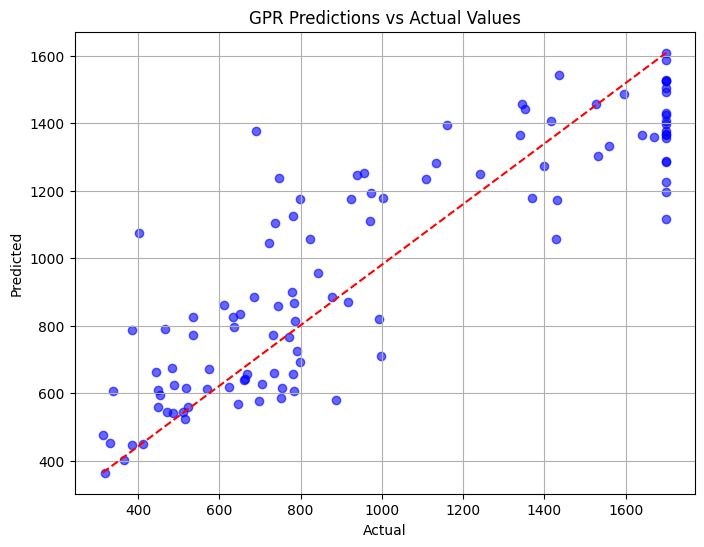

RMSE: 238.22496621724696
MSE: 56751.13452920846
Rsquared: 0.741780451977189


In [99]:
y_mean_test, y_std_train = gpr.predict(X_test, return_std= True)

target_y_mean_test = y_mean_test[:,0]

plt.figure(figsize=(8, 6))
plt.scatter(target_y_test, target_y_mean_test, color='blue', alpha=0.6)
plt.plot([target_y_test.min(), target_y_test.max()], [target_y_mean_test.min(), target_y_mean_test.max()], 'r--')  # reference line
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("GPR Predictions vs Actual Values")
plt.grid(True)
plt.show()

rmse = root_mean_squared_error(target_y_test, target_y_mean_test)
mse = mean_squared_error(target_y_test, target_y_mean_test)
r2 = r2_score(target_y_test, target_y_mean_test)

print(f"RMSE: {rmse}")
print(f"MSE: {mse}")
print(f"Rsquared: {r2}")

# pTAU


In [100]:
target = 'PTAU_bl'
target_y_train = y_train[target]
target_y_test  = y_test[target]

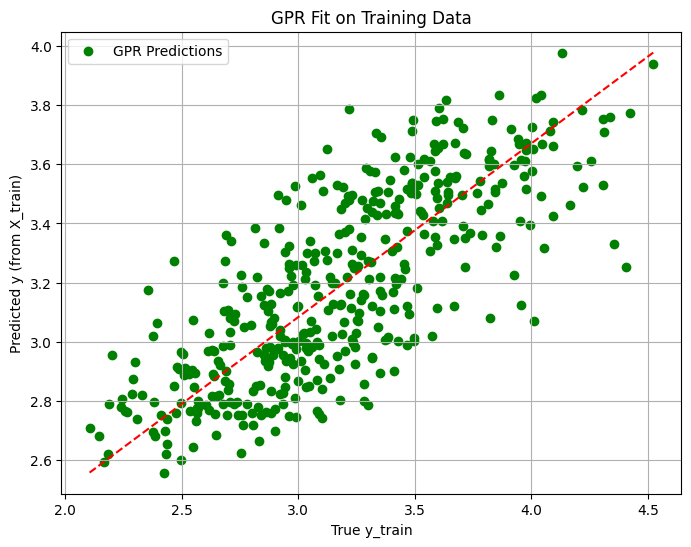

RMSE: 0.31859409733634747
MSE: 0.10150219885756204
Rsquared: 0.5772341656492931


In [101]:
y_mean_train, y_std_train = gpr.predict(X_train, return_std= True)


target_y_mean_train = y_mean_train[:,1]

plt.figure(figsize=(8, 6))
plt.scatter(target_y_train, target_y_mean_train, color='green', label='GPR Predictions')
plt.plot([target_y_train.min(), target_y_train.max()],
         [target_y_mean_train.min(), target_y_mean_train.max()],
         'r--') 
plt.xlabel("True y_train")
plt.ylabel("Predicted y (from X_train)")
plt.title("GPR Fit on Training Data")
plt.legend()
plt.grid(True)
plt.show()

rmse = root_mean_squared_error(target_y_train, target_y_mean_train)
mse = mean_squared_error(target_y_train, target_y_mean_train)
r2 = r2_score(target_y_train, target_y_mean_train)

print(f"RMSE: {rmse}")
print(f"MSE: {mse}")
print(f"Rsquared: {r2}")

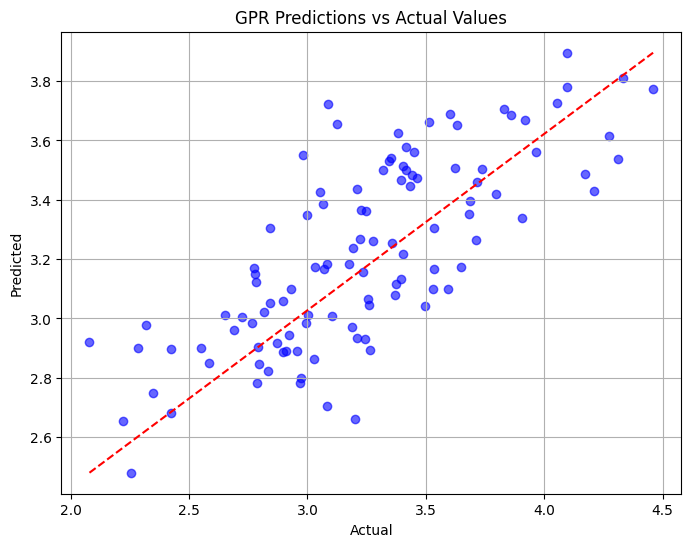

RMSE: 0.33081721239753326
MSE: 0.10944002801847462
Rsquared: 0.5512615202049977


In [102]:
y_mean_test, y_std_train = gpr.predict(X_test, return_std= True)

target_y_mean_test = y_mean_test[:,1]

plt.figure(figsize=(8, 6))
plt.scatter(target_y_test, target_y_mean_test, color='blue', alpha=0.6)
plt.plot([target_y_test.min(), target_y_test.max()], [target_y_mean_test.min(), target_y_mean_test.max()], 'r--')  # reference line
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("GPR Predictions vs Actual Values")
plt.grid(True)
plt.show()

rmse = root_mean_squared_error(target_y_test, target_y_mean_test)
mse = mean_squared_error(target_y_test, target_y_mean_test)
r2 = r2_score(target_y_test, target_y_mean_test)

print(f"RMSE: {rmse}")
print(f"MSE: {mse}")
print(f"Rsquared: {r2}")

# TAU

In [103]:
target = 'TAU_bl'
target_y_train = y_train[target]
target_y_test  = y_test[target]

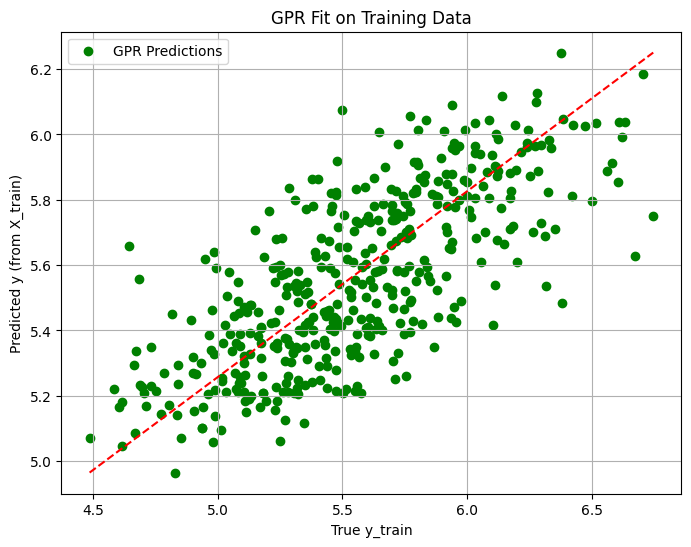

RMSE: 0.3091323023759546
MSE: 0.09556278037225863
Rsquared: 0.5211289797025929


In [104]:
y_mean_train, y_std_train = gpr.predict(X_train, return_std= True)


target_y_mean_train = y_mean_train[:,2]

plt.figure(figsize=(8, 6))
plt.scatter(target_y_train, target_y_mean_train, color='green', label='GPR Predictions')
plt.plot([target_y_train.min(), target_y_train.max()],
         [target_y_mean_train.min(), target_y_mean_train.max()],
         'r--') 
plt.xlabel("True y_train")
plt.ylabel("Predicted y (from X_train)")
plt.title("GPR Fit on Training Data")
plt.legend()
plt.grid(True)
plt.show()

rmse = root_mean_squared_error(target_y_train, target_y_mean_train)
mse = mean_squared_error(target_y_train, target_y_mean_train)
r2 = r2_score(target_y_train, target_y_mean_train)

print(f"RMSE: {rmse}")
print(f"MSE: {mse}")
print(f"Rsquared: {r2}")

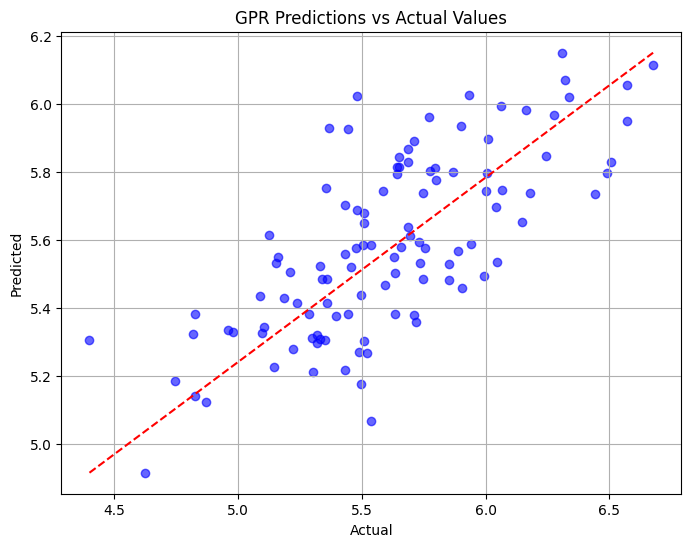

RMSE: 0.3104761307829119
MSE: 0.09639542778592783
Rsquared: 0.497639446192505


In [105]:
y_mean_test, y_std_train = gpr.predict(X_test, return_std= True)

target_y_mean_test = y_mean_test[:,2]

plt.figure(figsize=(8, 6))
plt.scatter(target_y_test, target_y_mean_test, color='blue', alpha=0.6)
plt.plot([target_y_test.min(), target_y_test.max()], [target_y_mean_test.min(), target_y_mean_test.max()], 'r--')  # reference line
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("GPR Predictions vs Actual Values")
plt.grid(True)
plt.show()

rmse = root_mean_squared_error(target_y_test, target_y_mean_test)
mse = mean_squared_error(target_y_test, target_y_mean_test)
r2 = r2_score(target_y_test, target_y_mean_test)

print(f"RMSE: {rmse}")
print(f"MSE: {mse}")
print(f"Rsquared: {r2}")